# Подготовка данных

### 1. Audio selection 

Разбиваем каждую аудиозапись на 10 записсей, детектриуя тишину между цифрами. 

### 2. Аугментация

* добавление шума (было добавлено 10к примеров с шумом)
* растягивание аудиозаписей (было добавлено 10к растянутых)
* в конце каждой аудиозаписи была добавлена тишина, чтобы каждая аудиозапись была длинной 3.5 мс

### 3. Feature extraction 
 
В качестве фичей было решено использовать следующие

    Zero Crossing Rate
    Chroma_stft
    MFCC
    RMS(root mean square) value
    MelSpectogram 


Эти фичи быстро считаются, удобно хранить и содержат в себе достаточно информации для предсказания. 

### 4. Гипотезы по улучшению

*  Добавить шум из датасета QUT-Noise (фоновый шум кафе, улиц и пр)
*  Добавить аугментацию pith и shifting time, например:

        def shift(data):
            shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
            return np.roll(data, shift_range)

        def pitch(data, sampling_rate, pitch_factor=0.7):
            return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
            
* Вместо предложенных фичей можно использовать Mel Спектрограммы, а также потом аугментировать картинки

In [1]:
import pandas as pd
import numpy as np

import sys
import glob


import soundfile as sf
import librosa
import librosa.display

from function import * 
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Define a function to normalize a chunk to a target amplitude.
def match_target_amplitude(aChunk, target_dBFS):
    ''' Normalize given audio chunk '''
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)


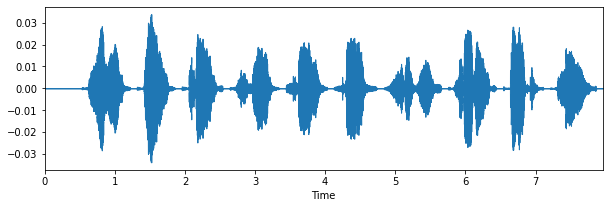

In [3]:
path = 'joined_v2/joined_v2/40_12.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

In [10]:
files = glob.glob('./joined_v2/joined_v2/*.wav', recursive=True)

In [11]:
len(files)

2950

### Разделяем аудиозаписи на сэмплы 


In [80]:
prog = 1
for ind , path in enumerate(files): 
    name = path[-9:-7]
    song = AudioSegment.from_file(path).set_frame_rate(sampling_rate)
    chunks = split_on_silence (song, min_silence_len = 20, silence_thresh = -100)
    for i, chunk in enumerate(chunks):
        # Create a silence chunk that's 0.5 seconds (or 500 ms) long for padding.
        silence_chunk = AudioSegment.silent(duration=500)

        # Add the padding chunk to beginning and end of the entire chunk.
        audio_chunk = silence_chunk + chunk + silence_chunk

        # Normalize the entire chunk.
        normalized_chunk = match_target_amplitude(audio_chunk, -20.0)

        normalized_chunk.export(
            "./audio_data_raw/{0}_label_{1}.wav".format(ind, i),
            bitrate = "192k",
            format = "wav"
        )
    print('Processed ({} of 2950)'.format(ind), end='\r', flush=True)
    

In [25]:
files_wac = glob.glob('./audio_data_noi/*.wav', recursive=True)

## Data Augmentation




In [29]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.7):
    return librosa.effects.time_stretch(data, rate)


In [30]:
path = files_wac[0]

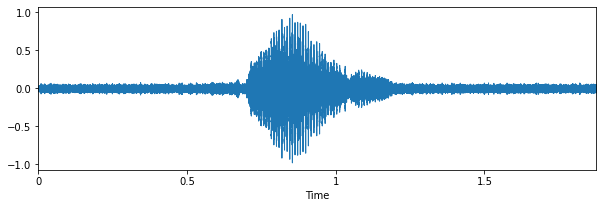

In [32]:
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

### Создаем записи с шумом

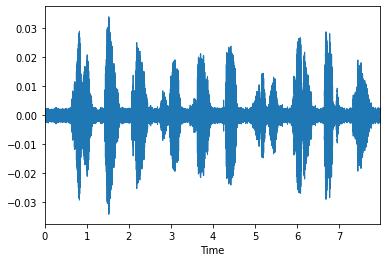

In [9]:
noised_audio = noise(data)
librosa.display.waveplot(y=noised_audio, sr=sampling_rate)
Audio(noised_audio, rate=sampling_rate)

In [36]:
files_wac = glob.glob('./audio_data_raw/*.wav', recursive=True)

In [46]:
%%time
for ind, file in enumerate(files_wac):
    name= file[17:-4]
    data, sampling_rate = librosa.load(file)
    noised_audio = noise(data)
    sf.write('./audio_data_noi/noised_{}.wav'.format(name), noised_audio, samplerate =sampling_rate, format='wav')
    print('Processed ({} of 29500)'.format(ind), end='\r', flush=True)

CPU times: user 1min 27s, sys: 14.5 s, total: 1min 41s
Wall time: 28min 16s


### Создаем растянутые записи

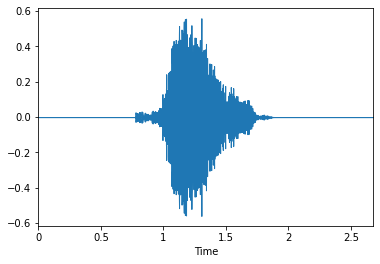

In [119]:
streched_audio = stretch(data)
librosa.display.waveplot(y=streched_audio, sr=sampling_rate)
Audio(streched_audio, rate=sampling_rate)

In [47]:
for ind, file in enumerate(files_wac):
    name= file[17:-4]
    data, sampling_rate = librosa.load(file)
    streched_audio = stretch(data)
    sf.write('./audio_data_str/streched_{}.wav'.format(name), streched_audio, samplerate =sampling_rate, format='wav')
    print('Processed ({} of 29500)'.format(ind), end='\r', flush=True)

### Паддим все аудио до одной размерности 3.5 мс


In [48]:
files = glob.glob('./audio_data_raw/*.wav', recursive=True)
files.extend(glob.glob('./audio_data_str/*.wav', recursive=True))
files.extend(glob.glob('./audio_data_noi/*.wav', recursive=True))

In [49]:
len(files)

88500

In [50]:
%%time
duration = 3000
for ind, file in enumerate(files): 
    song = AudioSegment.from_wav(file)  
    name = file[17:]
    allign = duration - len(song)
    silence_segment = AudioSegment.silent(duration=allign) 
    final_song = song + silence_segment

    final_song.export('./audio_all_padded/{}'.format(name), format="wav")
    print('Processed ({} of 49513)'.format(ind), end='\r', flush=True)
    

CPU times: user 2min 2s, sys: 39 s, total: 2min 41s
Wall time: 20min 15s


In [55]:
files = glob.glob('./audio_all_padded/*.wav', recursive=True)

In [57]:
len(files)

88500

./audio_all_padded/streched_1757_label_5.wav


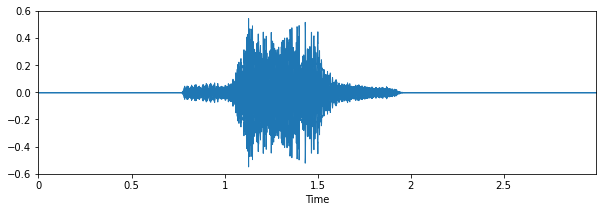

In [63]:
path = files[56779]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

### Feature Extraction

    Zero Crossing Rate
    Chroma_stft
    MFCC
    RMS(root mean square) value
    MelSpectogram to train our model.


In [64]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):  
    data, sample_rate = librosa.load(path, 22050)
    result = extract_features(data)
    result = np.array(result)
        
    return result

In [70]:
%%time
X, Y = [], []
for ind, path in enumerate(files):
    feature = get_features(path)
    label = int(path[-5])
    
    X.append(feature)        
    Y.append(label)
    print('Processed ({} of 49513)'.format(ind), end='\r', flush=True)

CPU times: user 1h 50min 40s, sys: 58min 27s, total: 2h 49min 8s
Wall time: 48min 55s


In [71]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.025135,0.243417,0.223568,0.224432,0.214661,0.215847,0.215759,0.179210,0.171767,0.184881,...,0.000544,0.001099,0.001018,0.000644,0.001452,0.002059,0.001701,0.000585,0.000055,4
1,0.235532,0.486834,0.504072,0.530648,0.535653,0.526460,0.485300,0.453868,0.470743,0.465463,...,0.039209,0.041903,0.044877,0.036837,0.035666,0.036926,0.038742,0.035703,0.035290,8
2,0.203380,0.465087,0.481194,0.505338,0.515634,0.499936,0.426317,0.409652,0.429763,0.471815,...,0.001540,0.001559,0.001813,0.001483,0.001208,0.000770,0.000647,0.000228,0.000074,3
3,0.028463,0.234542,0.227476,0.240169,0.276629,0.257199,0.218056,0.199159,0.198405,0.240206,...,0.000094,0.000138,0.000084,0.000153,0.000268,0.000296,0.000189,0.000042,0.000006,1
4,0.030784,0.281617,0.290601,0.319793,0.336846,0.324872,0.315245,0.291816,0.304768,0.292448,...,0.000492,0.000463,0.000325,0.000496,0.000731,0.000664,0.000525,0.000167,0.000015,3


In [72]:
len(X)

88500